In [6]:
import numpy as np
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,precision_score, accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,FixedLocator)
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')
import sys

In [7]:
clim1=1993
clim2=2016
year1=1993
year2=2016

In [8]:
dataset=Dataset("/work/bk1318/b382634/ERA5/HW_Indicators/Regridding_C3S/tmax_HWs_EUR_NDQ90_period{}{}_clim{}{}.nc".format(year1,year2,clim1,clim2),'r')
target_2D=dataset['NDQ90_May'][:,0,:,:]+dataset['NDQ90_Jun'][:,0,:,:]+dataset['NDQ90_Jul'][:,0,:,:]
#target_2D=target_2D[:,::-1,:]

lons=dataset['lon'][:]
lats=dataset['lat'][::-1]
lons_tile=np.tile(lons,lats.size)
lats_tile=np.tile(lats[::-1],lons.size)
print (lats)
#ds=xr.open_dataset("/work/bk1318/b382634/ERA5/ERA5_masks/ERA5_lsm_EUR.nc")
#ds_regrid = ds.interp(lat=lats, lon=lons)
#lsm=ds_regrid.var172.values[0]

[25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5]


In [9]:
def extract_C3S(name,ens,y1,y2,detr):
    data_c3s_NDQ90=np.zeros((ens,year2-year1+1,47,75))
    for i in range(ens):
        data_c3s=xr.open_dataset("/work/bk1318/b382634/C3S/{0}/HW_Indicators/tmax_HWs_EUR_MJJA_period{1}{2}_clim19932016_ens{3}{4}.nc".format(name,y1,y2,i+1,detr))
        data_c3s=data_c3s.assign_coords({"lon": ("lon", data_c3s.longitude.values)})
        data_c3s=data_c3s.assign_coords({"lat": ("lat", data_c3s.latitude.values)})
        
        data_c3s.coords['lon'] = (data_c3s.coords['lon'] + 180) % 360 - 180
        data_c3s.drop_vars("longitude")
        data_c3s.drop_vars("latitude")
        
        data_c3s = data_c3s.sortby(data_c3s.lon)
        data_c3s = data_c3s.sortby(data_c3s.lat)
        
        data_c3s = data_c3s.sel(lat=slice(25,72),lon=slice(-15,60))
        data_c3s_NDQ90[i]=data_c3s['NDQ90_May'].values[year1-y1:year2+1-y1,0,:,:]+data_c3s['NDQ90_Jun'].values[year1-y1:year2+1-y1,0,:,:]+data_c3s['NDQ90_Jul'].values[year1-y1:year2+1-y1,0,:,:]
        
    #data_c3s_NDQ90_med=np.median(data_c3s_NDQ90,axis=0)
    #data_c3s_NDQ90_mean=np.mean(data_c3s_NDQ90,axis=0)
    return data_c3s_NDQ90 #data_c3s_NDQ90_mean


In [10]:
ecmwf=extract_C3S("ECMWF-5",25,1981,2022,"")#[1993-1981:2021-1981]
cmcc=extract_C3S("CMCC-SPS35",40,1993,2016,"")#[1993-1981:2021-1981]
dwd=extract_C3S("DWD",30,1993,2016,"")#[1993-1981:2021-1981]
mf=extract_C3S("meteo_france",25,1993,2016,"")#[1993-1981:2021-1981]

MM=np.concatenate((ecmwf,cmcc,dwd,mf),axis=0)

data_c3s_NDQ90_med=np.median(MM,axis=0)
data_c3s_NDQ90_mean=np.mean(MM,axis=0)

In [11]:
preds=[]
names=["LR","SV","DT","RF","KN","AB","MLP","LGB"]
for name in names:
    file="/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_{}_ERA5remove_co2_19502022.nc".format(name)
    print (file)
    dataset=Dataset(file,'r')
    xs=dataset['lon'][:]#-0.5
    ys=dataset['lat'][:]#+0.5
    preds.append(dataset['pred'][:,1993-1979:2016-1979+1])

#file="/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_LTSM_ERA5_19502022.nc"
#print (file)
#dataset=Dataset(file,'r')
#preds.append(dataset['pred'][:,1993-1979:2016-1979+1])

/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_LR_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_SV_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_DT_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_RF_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_KN_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_AB_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/initMay_targMJJ_NDQ90_MLP_ERA5remove_co2_19502022.nc
/work/bk1318/b382634/DD_Seasonal_Forecasts/Test4_past2k/Forecasts_DD_BestNRMSE/ini

In [12]:
DD_maps=np.zeros((len(names),24,lats.size,lons.size))

print (len(preds[0]))
for m in range(len(names)):
    for p in range(len(preds[m])):
        lonp=lons_tile[p]
        latp=lats_tile[p]
        lonind=np.argwhere(lons==lonp)[0][0]
        latind=np.argwhere(lats==latp)[0][0]
        DD_maps[m,:,latind,lonind]=preds[m][p]

#DD_maps_med=np.median(DD_maps,axis=0)

3525


In [13]:
#for n in range(24):
#    plt.pcolormesh(DD_maps[-1][n],vmin=0,vmax=90)
#    plt.colorbar()
#    plt.show()

In [14]:
r_lat1=51
r_lat2=58
r_lon1=37
r_lon2=47
russiay=[r_lat1,r_lat2,r_lat2,r_lat1,r_lat1]
russiax=[r_lon1,r_lon1,r_lon2,r_lon2,r_lon1]

i_lat1=38
i_lat2=46
i_lon1=9
i_lon2=16
italyy=[i_lat1,i_lat2,i_lat2,i_lat1,i_lat1]
italyx=[i_lon1,i_lon1,i_lon2,i_lon2,i_lon1]

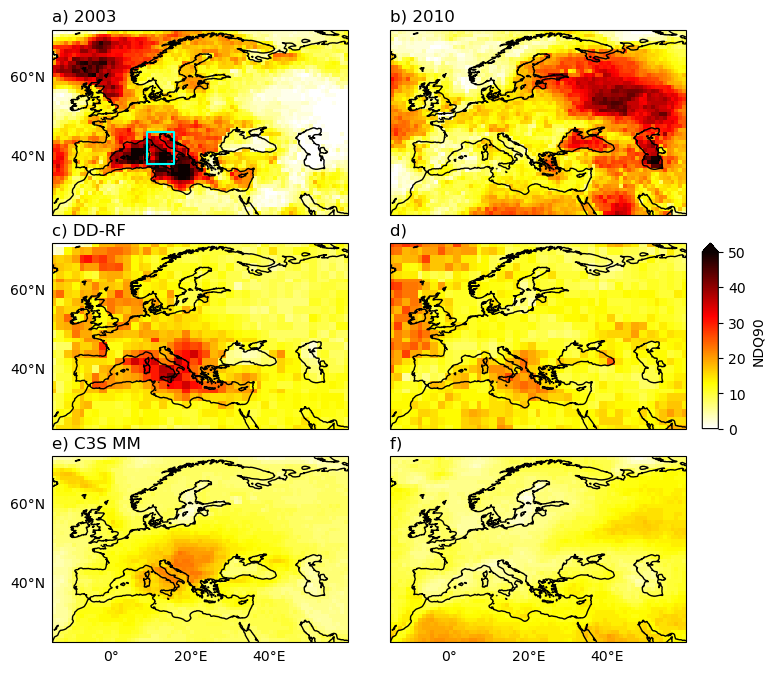

In [29]:
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(8,7),subplot_kw={'projection': ccrs.PlateCarree()} )
fig.subplots_adjust(bottom=0.075, top=0.95, left=0.075, right=0.9, wspace=0.05, hspace=0.15)

xx,yy=np.meshgrid(lons,lats)

p=0.05

y1=2003
y2=2010

mod=3

axes[0,0].set_title("a) "+str(y1),loc="left")
axes[0,1].set_title("b) "+str(y2),loc="left")
axes[1,0].set_title("c) DD-"+names[mod],loc="left")
axes[1,1].set_title("d) ",loc="left")
axes[2,0].set_title("e) C3S MM",loc="left")
axes[2,1].set_title("f) ",loc="left")


map1=axes[0,0].pcolormesh(lons,lats,target_2D[y1-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 
#axes[0,1].plot(russiax,russiay,'-',c='magenta',transform=ccrs.PlateCarree())
axes[0,0].plot(italyx,italyy,'-',c='cyan',transform=ccrs.PlateCarree())

axes[1,0].pcolormesh(lons,lats,DD_maps[mod,y1-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 
#axes[1,0].pcolormesh(lons,lats,DD_maps_med[y1-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 
axes[2,0].pcolormesh(lons,lats,data_c3s_NDQ90_med[y1-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 


axes[0,1].pcolormesh(lons,lats,target_2D[y2-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree())
axes[1,1].pcolormesh(lons,lats,DD_maps[mod,y2-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 
#axes[1,1].pcolormesh(lons,lats,DD_maps_med[y2-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 
axes[2,1].pcolormesh(lons,lats,data_c3s_NDQ90_med[y2-1993],cmap='hot_r',vmin=0,vmax=50,transform=ccrs.PlateCarree()) 

for i in range(3):
    for j in range(2):
        axes[i,j].add_feature(cfeature.COASTLINE,linewidth=1,zorder=1)
        gl = axes[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.0, color='lightgray', alpha=0.5, linestyle='--')
        axes[i,j].set_extent([-15,60,25,72],ccrs.PlateCarree())
        gl.xlocator=mticker.FixedLocator(np.arange(0,61,20))
        gl.ylocator=mticker.FixedLocator(np.arange(20,71,20))
        gl.top_labels=False
        gl.right_labels=False
        if j==1:
            gl.left_labels=False
        if i!=2:
            gl.bottom_labels=False
            
pos1=axes[1,1].get_position()
cb_ax1 = fig.add_axes([pos1.x1+0.02, pos1.y0, 0.02, pos1.y1-pos1.y0])
cbar1=plt.colorbar(map1, cax=cb_ax1,orientation='vertical',extend='max')
cbar1.set_label("NDQ90")

#plt.show()
plt.savefig("/work/bk1318/b382634/Paper_Figures/DD_SF/20032010.png",dpi=300)

In [27]:
r_x1=int(np.argwhere(lons>r_lon1)[0])
r_x2=int(np.argwhere(lons>r_lon2)[0])
r_y1=int(np.argwhere(lats>r_lat1)[0])
r_y2=int(np.argwhere(lats>r_lat2)[0])
i_x1=int(np.argwhere(lons>i_lon1)[0])
i_x2=int(np.argwhere(lons>i_lon2)[0])
i_y1=int(np.argwhere(lats>i_lat1)[0])
i_y2=int(np.argwhere(lats>i_lat2)[0])

(120, 24)
0 LR (0.7370789605493447, 3.98312869497636e-05)
1 SV (0.6621248763402781, 0.0004242456621034617)
2 DT (0.6413960407140636, 0.0007306941886477295)
3 RF (0.7032240573276101, 0.00012660209322521977)
4 KN (0.6551726362824624, 0.0005114015901306739)
5 AB (0.699314865005962, 0.00014323663682293527)
6 MLP (0.7278095790226187, 5.558318853459872e-05)
7 LGB (0.694800427603227, 0.00016479506744251321)


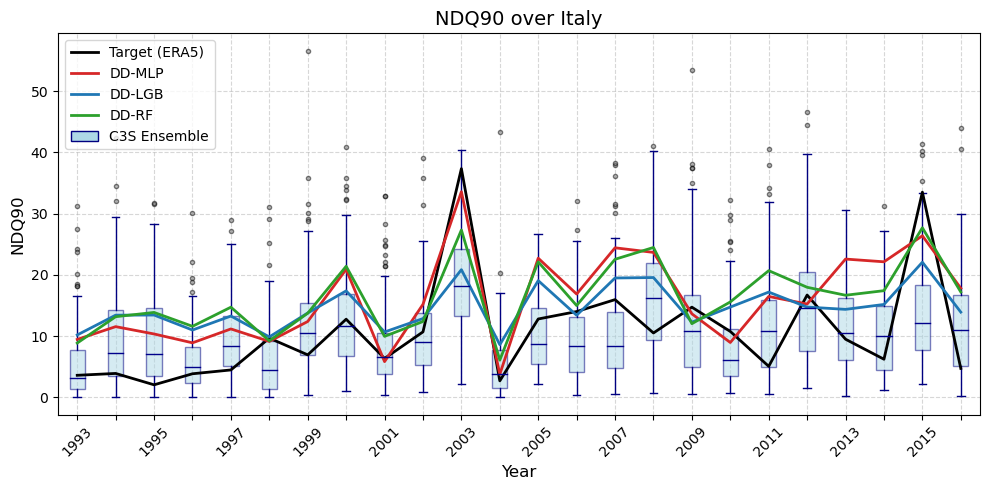

In [28]:
plt.figure(figsize=(10, 5))

# Generate x-axis
years = range(1993, 2017)

era5=np.mean(target_2D[:, i_y1:i_y2, i_x1:i_x2], axis=(1, 2))
#c3s=np.mean(data_c3s_NDQ90_med[:, i_y1:i_y2, i_x1:i_x2], axis=(1, 2))
C3S_MM=np.mean(MM[:, :,i_y1:i_y2, i_x1:i_x2], axis=(2, 3))
print (C3S_MM.shape)

plt.boxplot(C3S_MM, positions=years, widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy',alpha=0.5),
            medianprops=dict(color='darkblue'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markersize=3, linestyle='none', markerfacecolor='gray', alpha=0.5))


cols=['tab:green','tab:red','tab:orange']

#for n in [3,5,7]:#range(len(names)):
for n in range(len(names)):
    DD=np.mean(DD_maps[n, :, i_y1:i_y2, i_x1:i_x2], axis=(1, 2))
    print (n,names[n],sp.pearsonr(era5,DD))

# Plot each line with labels
target_line,=plt.plot(
    years,
    era5,
    'k-',
    label='Target (ERA5)',
    linewidth=2
)

dd_line,=plt.plot(
    years,
    np.mean(DD_maps[6, :, i_y1:i_y2, i_x1:i_x2], axis=(1, 2)),
    color='tab:red',
    label='DD-'+names[6],
    linestyle='-',
    linewidth=2
)
dd_line2,=plt.plot(
    years,
    np.mean(DD_maps[7, :, i_y1:i_y2, i_x1:i_x2], axis=(1, 2)),
    color='tab:blue',
    label='DD-'+names[7],
    linestyle='-',
    linewidth=2
)
dd_line3,=plt.plot(
    years,
    np.mean(DD_maps[3, :, i_y1:i_y2, i_x1:i_x2], axis=(1, 2)),
    color='tab:green',
    label='DD-'+names[3],
    linestyle='-',
    linewidth=2
)   
# Add grid, legend, and labels
plt.grid(True, linestyle='--', alpha=0.5)

box_legend = mpatches.Patch(facecolor='lightblue', edgecolor='navy', label='C3S Ensemble')
plt.legend(handles=[target_line, dd_line, dd_line2, dd_line3, box_legend])

plt.xlabel('Year', fontsize=12)
plt.ylabel('NDQ90', fontsize=12)
plt.title('NDQ90 over Italy', fontsize=14)
plt.xticks(ticks=years, labels=[str(y) if y % 2 == 1 else "" for y in years], rotation=45)
plt.tight_layout()

#plt.show()
plt.savefig("/work/bk1318/b382634/Paper_Figures/DD_SF/NorthItaly.png",dpi=300)
#print (sp.pearsonr(era5,C3S_MM))


In [ ]:
plt.figure(figsize=(10, 5))

# Generate x-axis
years = range(1993, 2017)

era5=np.mean(target_2D[:, r_y1:r_y2, r_x1:r_x2], axis=(1, 2))
#c3s=np.mean(data_c3s_NDQ90_med[:, i_y1:i_y2, i_x1:i_x2], axis=(1, 2))
C3S_MM=np.mean(MM[:, :,r_y1:r_y2, r_x1:r_x2], axis=(2, 3))
print (C3S_MM.shape)

plt.boxplot(C3S_MM, positions=years, widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy',alpha=0.5),
            medianprops=dict(color='darkblue'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markersize=3, linestyle='none', markerfacecolor='gray', alpha=0.5))

cols=['tab:green','tab:red','tab:orange']

for n in [3,5,7]:#range(len(names)):
    DD=np.mean(DD_maps[n, :, r_y1:r_y2, r_x1:r_x2], axis=(1, 2))
    print (names[n],sp.pearsonr(era5,DD))

# Plot each line with labels
target_line,=plt.plot(
    years,
    era5,
    'k-',
    label='Target',
    linewidth=2
)

dd_line,=plt.plot(
    years,
    np.mean(DD_maps[5, :, r_y1:r_y2, r_x1:r_x2], axis=(1, 2)),
    color='tab:red',
    label='DD: '+names[5],
    linestyle='-',
    linewidth=2
)

    
# Add grid, legend, and labels
plt.grid(True, linestyle='--', alpha=0.5)

box_legend = mpatches.Patch(facecolor='lightblue', edgecolor='navy', label='C3S Ensemble')
plt.legend(handles=[target_line, dd_line, box_legend])

plt.xlabel('Year', fontsize=12)
plt.ylabel('NDQ90', fontsize=12)
plt.title('NDQ90 over Russia', fontsize=14)
plt.xticks(ticks=years, labels=[str(y) if y % 2 == 1 else "" for y in years], rotation=45)
plt.tight_layout()

plt.show()

print (sp.pearsonr(era5,c3s))


In [ ]:
plt.pcolormesh(target_2D[2003-1993],vmin=0,vmax=50)
plt.colorbar()
plt.show()
plt.pcolormesh(DD_maps[3,2003-1993],vmin=0,vmax=50)
plt.colorbar()
plt.show()
plt.pcolormesh(data_c3s_NDQ90_med[2003-1993],vmin=0,vmax=50)
plt.colorbar()
plt.show()
# Area over Europe with > 10 HW days
plt.figure(figsize=(9,4))
plt.plot(target_2D[:,20,28],'k-')
plt.plot(DD_maps[3,:,20,28],'g-')
plt.plot(data_c3s_NDQ90_med[:,20,28],'b-')
plt.show()

print (sp.pearsonr(pc_era5,pc_c3s))
print (sp.pearsonr(pc_era5,pc_dd))

In [ ]:
pc_era5=[]
pc_c3s=[]
pc_dd=[]
thresh=21
for year in range(24):
    pc_era5.append(np.argwhere(target_2D[year]>thresh).shape[0])
    pc_c3s.append(np.argwhere(data_c3s_NDQ90_med[year]>thresh).shape[0])
    pc_dd.append(np.argwhere(DD_maps[3,year]>thresh).shape[0])

In [ ]:
# Area over Europe with > 10 HW days
plt.figure(figsize=(9,4))
plt.plot(pc_era5,'k-')
plt.plot(pc_c3s,'b-')
plt.plot(pc_dd,'g-')
plt.show()

print (sp.pearsonr(pc_era5,pc_c3s))
print (sp.pearsonr(pc_era5,pc_dd))